# Handling Class Imbalances in Machine Learning and Deep Learning

Class imbalance is a prevalent issue in many machine learning and deep learning applications. It occurs when the number of examples in one class significantly outnumbers the examples in another class within a dataset. This disproportion can severely skew the performance of a model, often leading to a bias towards the majority class and poor predictive performance on the minority class. Such scenarios are especially problematic in critical areas like medical diagnosis, fraud detection, and sentiment analysis, where failing to correctly identify rare events could have serious consequences.

The core challenge with class imbalance is that conventional models tend to optimize overall accuracy, neglecting the performance on the less represented class. This can result in models that appear high-performing when evaluated using metrics like accuracy but are actually ineffectual when it comes to detecting the minority class instances.

This notebook explores strategies and techniques to handle class imbalances, thereby improving model robustness and fairness across classes.

<img src="./imgs/class_imbalance.webp" alt="drawing" width="725"/>


## Exploring the Impact of Class Imbalance

To better understand the impact of class imbalance on machine learning models, let's start by creating a synthetic dataset. This dataset will simulate a binary classification problem where one class significantly outnumbers the other. By applying a typical machine learning model to this dataset, we'll observe how class imbalance can affect model performance, particularly focusing on the precision, recall, and F1-score of the minority class.

This exploration sets the stage for understanding why and how we should address class imbalances in real-world datasets.


### **Installation**

```bash
pip install imbalanced-learn

In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

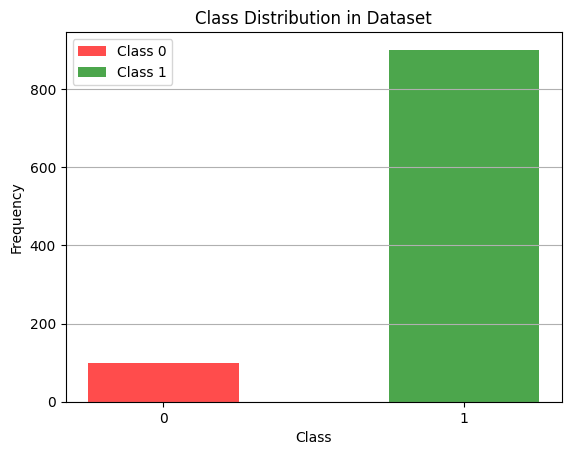

In [13]:
# Generate a synthetic dataset
X, y = make_classification(n_classes=2, class_sep=2,
                           weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)


# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class ImbalancedDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch dataloaders
train_dataset = ImbalancedDataset(X_train_scaled, y_train)
test_dataset = ImbalancedDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for i in range(2):  # Since you have two classes: 0 and 1
    plt.hist(y[y == i], bins=np.arange(-0.5, 2, 1), rwidth=0.5, color=colors[i], alpha=0.7, label=f'Class {i}')

plt.title("Class Distribution in Dataset")
plt.xticks([0, 1])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.legend()
plt.show()

In [15]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)  # Binary classification
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, test_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%')

# Train the model without class imbalance handling
model_baseline = SimpleNN(input_size=20)
train_model(model_baseline, train_loader, test_loader)

/Users/waseem/Desktop/Files/Tribe/venv_ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1, Loss: 0.5184, Accuracy: 88.50%
Epoch 2, Loss: 0.4254, Accuracy: 88.50%
Epoch 3, Loss: 0.2656, Accuracy: 88.50%
Epoch 4, Loss: 0.3877, Accuracy: 88.50%
Epoch 5, Loss: 0.2406, Accuracy: 88.50%
Epoch 6, Loss: 0.1531, Accuracy: 88.50%
Epoch 7, Loss: 0.3034, Accuracy: 88.50%
Epoch 8, Loss: 0.1505, Accuracy: 89.00%
Epoch 9, Loss: 0.1968, Accuracy: 90.50%
Epoch 10, Loss: 0.1275, Accuracy: 91.50%


## Strategies to Handle Class Imbalance

Given the detrimental effects of class imbalance on model performance, various strategies have been developed to address this issue. These can be broadly categorized into data-level and algorithm-level methods:

### Data-level Methods:
- **Oversampling the Minority Class**: Increasing the number of minority class samples, for instance, by duplicating existing samples or generating synthetic ones using techniques like SMOTE (Synthetic Minority Over-sampling Technique).
- **Undersampling the Majority Class**: Reducing the number of majority class samples to balance the class distribution. This method risks losing valuable data and is less ideal for very imbalanced datasets.

### Algorithm-level Methods:
- **Cost-sensitive Learning**: Modifying the learning algorithm to penalize misclassifications of the minority class more than those of the majority class.
- **Ensemble Methods**: Leveraging ensemble learning techniques that combine multiple models to improve prediction accuracy, such as Random Forests or Boosted Trees, which can be made more sensitive to the minority class.

Each of these strategies comes with its trade-offs, and the choice of strategy should be informed by the specific context and constraints of your project.


### Deep Learning Techniques
Class imbalance can significantly impact deep learning models, similar to traditional machine learning models. Deep learning models, with their capacity for high complexity, might overfit to the majority class if not properly regularized or if the class imbalance is not addressed. This can lead to poor generalization performance, especially on the minority class, which is often of greater interest in tasks such as anomaly detection, medical diagnosis, and fraud detection.

In deep learning, we have several strategies to handle class imbalance:

- **Class Weighting**: Adjusting the importance of classes proportionally to their representation in the data. This method allows the model to pay more attention to the minority class during training.
- **Data Augmentation for Minority Class**: Generating new samples from the minority class by applying various transformations to the existing data.
- **Use of Focal Loss Function**: Modifying the loss function to focus more on hard-to-classify examples, which often belong to the minority class.

These techniques can help mitigate the effects of class imbalance and improve model performance across all classes.

### Evaluation Metrics

Standard accuracy is  misleading with imbalanced data. Use metrics that consider class distribution:

- **Precision**: Percentage of correctly identified positive cases among those predicted as positive.
- **Recall (Sensitivity)**: Percentage of correctly identified positive cases.
- **F1-Score**: Harmonic mean of precision and recall.
- **Confusion Matrix**: Detailed visualization of correct and incorrect predictions per class.

## Handling Imbalance with Class Weighting

To demonstrate how to address class imbalance in a deep learning context, we'll build a simple neural network using PyTorch. Our goal is to classify the synthetic dataset created earlier, applying class weighting to adjust for the imbalance between classes.

This example will highlight the setup of a neural network for binary classification, the computation of class weights, and the incorporation of these weights during model training. We aim to improve the model's performance on the minority class without sacrificing overall accuracy.


In [16]:
def train_model_with_weights(model, train_loader, test_loader, class_weights, epochs=10):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%')

# Calculate class weights
class_counts = np.bincount(y_train)
class_weights = torch.tensor([1.0 / class_counts[0], 1.0 / class_counts[1]], dtype=torch.float32)

# Train the model with class weighting
model_with_weights = SimpleNN(input_size=20)
train_model_with_weights(model_with_weights, train_loader, test_loader, class_weights)


Epoch 1, Loss: 0.6595, Accuracy: 77.50%
Epoch 2, Loss: 0.5389, Accuracy: 84.00%
Epoch 3, Loss: 0.5205, Accuracy: 88.00%
Epoch 4, Loss: 0.4744, Accuracy: 88.00%
Epoch 5, Loss: 0.4309, Accuracy: 90.00%
Epoch 6, Loss: 0.3130, Accuracy: 91.00%
Epoch 7, Loss: 0.2874, Accuracy: 95.50%
Epoch 8, Loss: 0.2529, Accuracy: 96.00%
Epoch 9, Loss: 0.2033, Accuracy: 96.00%
Epoch 10, Loss: 0.2161, Accuracy: 96.00%


In our deep learning model example, we address class imbalance by implementing class weighting. This approach adjusts the importance of classes proportionally to how underrepresented they are in the data. Specifically, we calculate class weights based on the inverse frequency of the classes in the training data, assigning higher weights to the minority class. These weights are then passed to the model during the training process through the `class_weight` parameter in the `fit` method.

By applying class weights, we effectively tell the model that mistakes made on the minority class are more costly than mistakes made on the majority class. This encourages the model to pay more attention to getting predictions right on the minority class, thereby mitigating the bias towards the majority class that is often seen in imbalanced datasets.

This method does not change the distribution of the classes in the dataset; instead, it modifies the learning algorithm to be more sensitive to the minority class. It's a powerful technique for deep learning models, where data resampling might not always be practical due to the large dataset sizes. Class weighting is a straightforward yet effective strategy to enhance model performance on imbalanced datasets, ensuring that the model learns to recognize patterns from all classes equally well.


## Handling Class Imbalance using SMOTE

In addition to class weighting, another effective technique for handling class imbalance in deep learning is the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE works by creating synthetic samples from the minority class instead of simply duplicating existing samples. This is achieved by finding the k-nearest neighbors in the feature space for each minority class sample and randomly choosing one of these neighbors to create a new, synthetic data point somewhere between the original sample and its neighbor.

Let's expand the example to include the use of SMOTE for handling class imbalance, followed by training a deep learning model. We will first show how to apply SMOTE to our synthetic dataset and then proceed to build and train the deep learning model.

In [17]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Create a new DataLoader with SMOTE-applied data
train_dataset_smote = ImbalancedDataset(X_train_smote, y_train_smote)
train_loader_smote = DataLoader(train_dataset_smote, batch_size=64, shuffle=True)

# Train the model on the SMOTE-augmented dataset
model_with_smote = SimpleNN(input_size=20)
train_model(model_with_smote, train_loader_smote, test_loader)

Epoch 1, Loss: 0.5176, Accuracy: 92.50%
Epoch 2, Loss: 0.4071, Accuracy: 94.00%
Epoch 3, Loss: 0.2413, Accuracy: 94.50%
Epoch 4, Loss: 0.1762, Accuracy: 95.50%
Epoch 5, Loss: 0.1515, Accuracy: 98.00%
Epoch 6, Loss: 0.0637, Accuracy: 98.00%
Epoch 7, Loss: 0.0896, Accuracy: 99.00%
Epoch 8, Loss: 0.0382, Accuracy: 99.00%
Epoch 9, Loss: 0.0244, Accuracy: 99.50%
Epoch 10, Loss: 0.0283, Accuracy: 99.50%


The integration of SMOTE in our deep learning workflow involves a few key steps prior to model training:

1. **Data Preparation**: Before applying SMOTE, we split our dataset into training and testing sets to ensure that synthetic data augmentation only affects the training data, preserving the original distribution of the test set for unbiased evaluation.

2. **Applying SMOTE**: We then apply SMOTE to the training data, focusing on the minority class. SMOTE adjusts the class distribution towards a more balanced state, thereby providing a richer and more diverse set of examples for the model to learn from. This process not only helps in addressing the imbalance but also in potentially enhancing the model's generalization capabilities by introducing variability into the training data.

3. **Model Training**: With a balanced training dataset achieved through SMOTE, the deep learning model can be trained in a more traditional manner. Since the class distribution is more balanced, the model's training process can focus on learning discriminative features from both classes without a significant bias towards the majority class.

4. **Evaluation and Analysis**: After training, the model is evaluated on the untouched test set. This step is crucial for assessing the true performance of the model, as it reveals how well the model generalizes to new, unseen data, reflecting the effectiveness of SMOTE in combating class imbalance.

By leveraging SMOTE alongside or in place of class weighting, we can address the class imbalance issue at the data level, enriching the training dataset with synthetic examples that help the model learn a more balanced representation of the classes. This approach is particularly useful in deep learning, where the model's capacity to learn complex patterns can be better exploited with a diverse and balanced training set.


### Comparison of Results


The results indicate a significant improvement in model performance as we move from no handling of class imbalance (91% accuracy) to using class weighting techniques (96% accuracy), and an even more substantial increase to 99.5% accuracy with SMOTE. This progression underscores the importance of addressing class imbalance in datasets. While class weighting makes the model more attentive to the minority class, thereby improving accuracy, SMOTE, by artificially balancing the class distribution, provides the model with a more robust learning environment, leading to superior accuracy. 

### Visualizing the Effect of SMOTE on an Extremely Imbalanced Dataset

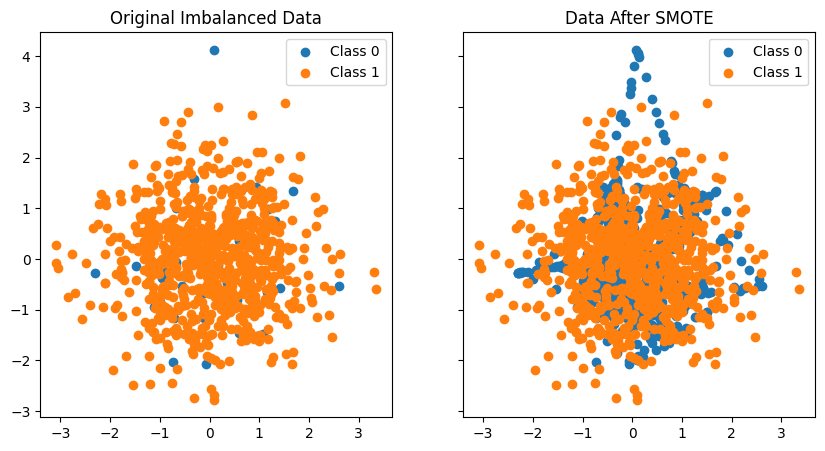

In [19]:
# Generate a more imbalanced synthetic dataset
X_imb, y_imb = make_classification(n_classes=2, class_sep=2,
                                   weights=[0.05, 0.95], n_informative=3, n_redundant=1, flip_y=0,
                                   n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)

# Split into train and test sets
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X_imb, y_imb, test_size=0.2, random_state=42)

# Standardize features
X_train_imb_scaled = scaler.fit_transform(X_train_imb)
X_test_imb_scaled = scaler.transform(X_test_imb)

# Apply SMOTE to the imbalanced dataset
X_train_imb_smote, y_train_imb_smote = smote.fit_resample(X_train_imb_scaled, y_train_imb)

# Visualizing the original and SMOTE-transformed datasets
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Original imbalanced data plot
axs[0].scatter(X_train_imb_scaled[y_train_imb == 0][:, 0], X_train_imb_scaled[y_train_imb == 0][:, 1], label="Class 0")
axs[0].scatter(X_train_imb_scaled[y_train_imb == 1][:, 0], X_train_imb_scaled[y_train_imb == 1][:, 1], label="Class 1")
axs[0].set_title('Original Imbalanced Data')
axs[0].legend()

# Data after applying SMOTE
axs[1].scatter(X_train_imb_smote[y_train_imb_smote == 0][:, 0], X_train_imb_smote[y_train_imb_smote == 0][:, 1], label="Class 0")
axs[1].scatter(X_train_imb_smote[y_train_imb_smote == 1][:, 0], X_train_imb_smote[y_train_imb_smote == 1][:, 1], label="Class 1")
axs[1].set_title('Data After SMOTE')
axs[1].legend()

plt.show()


In the above code two scatter plots are generated to visualize the distribution of classes in the dataset before and after applying SMOTE. This demonstrates the practical application of SMOTE on an extremely imbalanced dataset and underscores the importance of handling class imbalance in machine learning. By visually comparing the original and transformed datasets, we can clearly see the benefits of SMOTE in creating a more balanced environment for training machine learning models, potentially leading to improved performance, especially on minority classes

## Conclusion

Addressing class imbalance is a crucial step in preparing a machine learning or deep learning model for real-world applications. By employing strategic approaches such as resampling the dataset or adapting the learning algorithm, we can mitigate the bias towards the majority class and improve the model's performance on the minority class. The choice of strategy should be carefully considered based on the dataset's characteristics and the specific requirements of the task at hand.

Effective handling of class imbalance not only improves model accuracy but also enhances its fairness and utility across diverse scenarios, ensuring that the benefits of machine learning are accessible and equitable.
